In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
def read_data():
    df = pd.read_csv('data/post_processed/players.csv')
    df.shape
    df.columns.values
    df.head()
    return df

In [3]:
columns_to_cluster_by = [   'Points',
       "Points per player's possession", 'Field goals made',
       'Field goals attempted', 'Field goals, %', '2-pt field goals made',
       '2-pt field goals attempted', '2-pt field goals, %',
       '3-pt field goals made', '3-pt field goals attempted',
       '3-pt field goals, %', 'Free throws made', 'Free throws attempted',
       'Free throws, %', 'Rebounds', 'Offensive rebounds',
       'Defensive rebounds', 'Assists', 'Points off assists',
       'Screen Assist', 'Points off screen assists', 'Secondary Assist',
       'Steals', 'Turnovers', 'Blocks', 'Deflections', 'Fouls',
       'Fouls drawn', 'Transitions made', 'Transitions attempted',
       'Transition attacks, %', 'Catch and shoot made',
       'Catch and shoot attempted', 'Catch and shoot shots made, %',
       'Catch and drive made', 'Catch and drive attempted',
       'Catch and drive shots made, %', 'Screens off made',
       'Screens off attempted', 'Screens off, %', 'Posts up made',
       'Posts up attempted', 'Post up, %', 'Isolations made',
       'Isolations attempted', 'Isolation, %', 'Hand off made',
       'Hand off attempted', 'Hand off, %', 'Cuts made', 'Cuts attempted',
       'Cuts, %', 'PnR Handlers made', 'PnR Handlers attempted',
       'PR Handler, %', 'PnR Rollers made', 'PnR Rollers attempted',
       'PR Roller, %', 'PnP made', 'PnP attempted', 'Pick-n-pops, %',
       'Uncontested field goals made', 'Uncontested field goals',
       'Uncontested field goals, %', 'Contested field goals made',
       'Contested field goals', 'Contested field goals, %',
       "Opponent's field goals made", "Opponent's field goals attempted",
       "Opponent's field goals, %", "Number of player's possessions",
       'Team points with player', 'Offensive rating',
       'Opponent possessions played', "Opponent's points with player",
       'Defensive rating', 'Plus/Minus', 'Net rating',
       'Assists to turnovers', 'Steals to turnovers', 'Draw foul rate',
       'True shooting percentage', 'Effective field goal percentage',
       'Usage Percentage', 'Opp Transition shots made',
       'Opp Transition shots', 'Opponent Transition shots made, %',
       'Opp catch and shoot shots made', 'Opp catch and shoot shots',
       'Opp Catch and shoot shots made, %',
       'Opp catch and drive shots made', 'Opp Catch and drive shots',
       'Opp Catch and drive shots made, %', 'Opp Screens off shots made',
       'Opp Screens off shots', 'Opponent Screens off shots made, %',
       'Opp Post up shots made', 'Opp Post up shots',
       'Opponent Post up shots made, %', 'Opp Isolations shots made',
       'Opp Isolations shots', 'Opponent Isolation shots made, %',
       'Opp Hand off shots made', 'Opp Hand off shots',
       'Opponent Hand off shots made, %', 'Opp Cuts shots made',
       'Opp Cuts shots', 'Opponent Cuts shots made, %',
       'Opp Pick-n-roll shots made', 'Opp Pick-n-roll shots',
       'Opponent Pick-n-roll shots made, %', 'Opp Pick-n-Pop shots made',
       'Opp Pick-n-Pop shots', 'Opponent Pick-n-Pop shots made, %',
       'Drives made', 'Drives with shot', 'Drives, %',
       'Right drives made', 'Right drives', 'Right drives made, %',
       'Left drives made', 'Left drives', 'Left drives made, %',
       'Opp Drives shots made', 'Opp Drives shots',
       'Opponent Drives shots made, %' ,
                        "minutes_in_seconds"]

list_of_pct_cols = [
    
"Field goals, %",
"2-pt field goals, %",
"3-pt field goals, %",
"Free throws, %",
"Transition attacks, %",
"Catch and shoot shots made, %",
"Catch and drive shots made, %",
"Screens off, %",
"Post up, %",
"Isolation, %",
"Hand off, %",
"Cuts, %",
"PR Handler, %",
"PR Roller, %",
"Pick-n-pops, %",
"Uncontested field goals, %",
"Contested field goals, %",
"Opponent's field goals, %",
"True shooting percentage",
"Effective field goal percentage",
# "Usage Percentage",
"Opponent Transition shots made, %",
"Opp Catch and shoot shots made, %",
"Opp Catch and drive shots made, %",
"Opponent Screens off shots made, %",
"Opponent Post up shots made, %",
"Opponent Isolation shots made, %",
"Opponent Hand off shots made, %",
"Opponent Cuts shots made, %",
"Opponent Pick-n-roll shots made, %",
"Opponent Pick-n-Pop shots made, %",
"Drives, %",
"Right drives made, %",
"Left drives made, %",
"Opponent Drives shots made, %"  ]




In [4]:

def convert_minutes_to_sec(time_str):
    minutes, seconds = time_str.split(":")
    total_seconds = int(minutes) * 60 + int(seconds)
    return total_seconds

def preprocess_data(df):
    # convert minutes
    df['minutes_in_seconds'] = df['Minutes'].apply(lambda x: convert_minutes_to_sec(x))    
    
    # convert percentages
    for col in list_of_pct_cols:
        df[col] = df[col].str.replace('%', '').astype(float) / 100

    return df


def aggregate_player_data(raw_data,columns_to_cluster_by):
    # aggreate data to an avg 
    
    avg_player = raw_data.groupby(['id','player_name','team_name']).mean()[columns_to_cluster_by]
    return avg_player

def aggregate_team_data(raw_data,columns_to_cluster_by):
    # aggregate team data historically
    avg_team = df.groupby(['team_name','game_id']).sum().groupby('team_name').mean()[columns_to_cluster_by]
    return avg_team


df = read_data()
df = preprocess_data(df)
agg_df = aggregate_player_data(df,columns_to_cluster_by)
agg_team_df = aggregate_team_data (df,columns_to_cluster_by)

In [5]:
def prep_data_for_clustering(agg_df,agg_team_df):
    # take data and prep for clustering
    # standardize columns
    scaler_players = StandardScaler()
    scaler_teams   = StandardScaler()
    df_standardized_player = pd.DataFrame(scaler_players.fit_transform(agg_df),
                                          columns=agg_df.columns,
                                          index=agg_df.index)
    df_standardized_team = pd.DataFrame(scaler_teams.fit_transform(agg_team_df),
                                        columns=agg_team_df.columns,
                                        index=agg_team_df.index)

    # select relevant columns
    # validate that the columns are normalized to the team ( z scores )
    return df_standardized_player, df_standardized_team

def normalize_player_to_team(    df_standardized_player, df_standardized_team):
    # calculate the Z score of a players stat compared to league
    # calclaute the Z score of the teams avg stat compared to the league
    # subtraxct the players `z score witth the team to get the adjusted 
    result = df_standardized_player.sub(df_standardized_team.loc[df_standardized_player.index.get_level_values(2),
                                                            columns_to_cluster_by ].set_index(df_standardized_player.index), 
                                    axis=0)

    return result

def cluster_exploration(data , max_clusters=15):
    # run clustering model on all players - run on set of clusters from 5-30
    # pass
    best_clusters = 0
    best_silhouette_score = -1

    # Loop over different numbers of clusters to find the best one
    for n_clusters in range(2, max_clusters + 1):
        # Create KMeans model with n_clusters
        kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)

        # Fit the model to the data and get cluster labels
        cluster_labels = kmeans_model.fit_predict(data)

        # Calculate silhouette score for the clustering
        silhouette = silhouette_score(data, cluster_labels)
        print(n_clusters, silhouette)
        # If the silhouette score is better than previous best score, update variables
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_clusters = n_clusters

    return best_clusters, cluster_labels

# def cluster(data, num_of_clusters):
#     # Cluster the data and get the resulting labels
#     kmeans_model = KMeans(n_clusters=num_of_clusters, random_state=42)

#     # Fit the model to the data and get cluster labels
#     cluster_labels = kmeans_model.fit_predict(data)

#     # Add the cluster labels as a new column to the DataFrame
#     data['Cluster_Labels'] = cluster_labels
#     return data

from sklearn.cluster import AgglomerativeClustering

def cluster(data, num_of_clusters):
    # Cluster the data and get the resulting labels
    clustering = AgglomerativeClustering(n_clusters=num_of_clusters)

    # Fit the model to the data and get cluster labels
    cluster_labels = clustering.fit_predict(data)

    # Add the cluster labels as a new column to the DataFrame
    data['Cluster_Labels'] = cluster_labels
    return data

def assign_labels():
    # asign labels to players
    pass

def plot_labels():
    # plot PCA of player attributes
    pass

df_standardized_player, df_standardized_team = prep_data_for_clustering(agg_df, agg_team_df)

In [6]:
result = df_standardized_player.sub(df_standardized_team.loc[df_standardized_player.index.get_level_values(2),
                                                            columns_to_cluster_by ].set_index(df_standardized_player.index), 
                                    axis=0)


In [7]:
result.drop_duplicates().head()


,,,Points,Points per player's possession,Field goals made,Field goals attempted,"Field goals, %",2-pt field goals made,2-pt field goals attempted,"2-pt field goals, %",3-pt field goals made,3-pt field goals attempted,...,Right drives made,Right drives,"Right drives made, %",Left drives made,Left drives,"Left drives made, %",Opp Drives shots made,Opp Drives shots,"Opponent Drives shots made, %",minutes_in_seconds
id,player_name,team_name,,,,,,,,,,,,,,,,,,,,,
0,Jordan McRae,Hapoel SP Tel Aviv,0.323011,0.098485,0.146392,1.526017,-0.355960,-0.301946,-0.116089,-0.370666,1.878927,2.467021,...,-0.279474,0.404777,-0.932415,1.206362,1.586438,-0.183693,-0.476008,-0.239608,-0.622679,1.158308
1,Xavier Munford,Hapoel SP Tel Aviv,-0.119143,0.114373,-0.411176,1.060169,-0.384085,-0.998388,-0.875851,-0.277780,1.960904,2.632529,...,0.559430,1.030772,-0.482878,0.727194,1.327334,-0.142203,1.092025,1.051366,0.403170,1.049630
2,J'Covan Brown,Hapoel SP Tel Aviv,-0.445170,-0.302963,-0.743531,0.766967,-0.804552,-1.465262,-1.141860,-0.684001,2.119392,2.431783,...,-0.579919,0.044589,-1.604921,1.030667,1.301423,0.362364,-1.006727,-1.223448,-1.174764,0.970262
3,Tomer Ginat,Hapoel SP Tel Aviv,-0.423616,0.317041,-0.168574,0.988058,0.043033,-0.112789,-0.083979,-0.046303,0.690916,1.351175,...,-0.146625,0.319018,-1.445177,-0.383261,0.048262,-1.680184,0.218981,-0.562251,0.506441,0.800923
4,Idan Zalmanson,Hapoel SP Tel Aviv,-1.245993,-0.144148,-1.104310,0.117196,0.095209,-0.897791,-0.831268,-0.125447,0.015324,0.693414,...,-1.266650,-0.209661,-2.554343,-0.550590,-0.218656,-1.985201,0.054711,-0.332423,0.487821,-0.253715


In [8]:
result.describe()

,Points,Points per player's possession,Field goals made,Field goals attempted,"Field goals, %",2-pt field goals made,2-pt field goals attempted,"2-pt field goals, %",3-pt field goals made,3-pt field goals attempted,...,Right drives made,Right drives,"Right drives made, %",Left drives made,Left drives,"Left drives made, %",Opp Drives shots made,Opp Drives shots,"Opponent Drives shots made, %",minutes_in_seconds
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.011756,0.037052,0.029715,0.052669,0.042468,0.047236,0.064349,0.031078,-0.043314,-0.044895,...,0.033669,0.040424,0.034956,-0.068781,-0.048556,-0.026223,0.043046,0.042973,0.052511,0.014848
std,1.414533,1.260500,1.425829,1.422960,1.290885,1.409077,1.428019,1.281124,1.270075,1.286930,...,1.333370,1.313567,1.299648,1.375479,1.372558,1.345009,1.250600,1.347504,1.256944,1.433732
min,-2.991401,-3.500631,-2.661840,-2.571448,-3.457384,-2.571830,-2.713079,-3.450957,-2.893387,-2.647170,...,-1.927493,-2.110266,-3.503764,-3.212263,-2.374578,-2.383135,-2.373610,-2.811946,-2.725654,-3.281161
25%,-1.064626,-0.756990,-1.111919,-1.033528,-0.813417,-1.015895,-1.050254,-0.905842,-0.726068,-0.969262,...,-1.012961,-1.022760,-0.807113,-0.643921,-1.015095,-0.910653,-0.904020,-1.019578,-0.912923,-0.857546
50%,-0.010570,0.336368,0.044124,0.019285,0.291776,-0.032426,0.140171,0.296679,-0.022234,-0.002972,...,-0.156760,-0.215940,-0.072409,-0.009025,-0.106508,-0.109752,0.024765,0.033058,0.039498,-0.127593
75%,1.076330,0.954332,0.989013,1.008609,0.998290,1.081195,0.995213,0.971066,0.863418,0.804586,...,0.900931,0.839335,0.719942,0.630936,0.844068,0.855814,0.865177,0.926471,0.894039,0.928433
max,3.736430,2.751987,3.838175,5.643655,3.860165,3.750674,4.588557,2.928044,3.617367,3.755665,...,5.350894,5.016646,5.586076,4.133888,3.523662,4.316598,4.403170,4.184508,3.159931,3.096119


In [9]:
cluster_exploration(result , 20)

2 0.18848274321398106
3 0.15331882495840835
4 0.14795872683854763
5 0.14190959450675236
6 0.14268287269909286
7 0.1572670234613524
8 0.15768903179369892
9 0.16139467382339154
10 0.16001139015259205
11 0.16422977123035162
12 0.17505903481682245
13 0.1810530190672822
14 0.19808545176901746
15 0.18617320938255946
16 0.1914861597807293
17 0.18773943028449264
18 0.2054528973600277
19 0.20267335759380573
20 0.19228983912914804


(18,
 array([ 6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  1,  4,  1, 18, 18, 18,
         8,  4,  8, 18, 18, 18, 12, 12,  3, 12, 12,  3,  3, 12, 12,  3, 12,
         4, 14,  4, 19, 19, 19, 19, 19, 14,  7, 11, 11, 11,  6, 11, 11, 15,
        14,  8,  8,  8,  4, 14,  2,  8,  2,  2,  2, 14,  4,  8, 14, 17, 17,
        17, 17, 17,  1,  7,  7,  7,  7,  5,  5,  7,  5,  2,  2,  2, 11, 15,
         6,  9,  4, 14,  4, 10,  4, 10, 10, 10, 10,  7,  1,  5,  7,  7,  7,
         7,  5,  5,  7,  4, 13, 13, 13, 13, 13, 13, 16,  1, 11, 15, 15, 17,
         1,  4,  8,  0, 11,  0,  0,  1,  0,  4, 10, 10, 14,  4, 19, 19,  2,
         6,  9,  5, 14,  7,  5, 13, 14, 13, 13, 16, 13, 16,  5,  4,  0,  0,
         4, 16,  3,  3, 18, 12, 15, 15, 15, 12,  7,  7,  0, 19,  7,  4,  5,
        19, 14,  7,  7, 14,  1, 18, 10,  2, 15, 12,  8,  5, 16, 16, 16, 10,
        10,  0,  5, 17, 14,  2,  1, 18, 18, 10, 16,  9,  8, 19, 17, 16,  0,
        11, 17, 16, 17], dtype=int32))

In [10]:
# cluster_exploration(result , 20)
clusters_with_labels = cluster(result , num_of_clusters=17)
clusters_with_labels.head()

,,,Points,Points per player's possession,Field goals made,Field goals attempted,"Field goals, %",2-pt field goals made,2-pt field goals attempted,"2-pt field goals, %",3-pt field goals made,3-pt field goals attempted,...,Right drives,"Right drives made, %",Left drives made,Left drives,"Left drives made, %",Opp Drives shots made,Opp Drives shots,"Opponent Drives shots made, %",minutes_in_seconds,Cluster_Labels
id,player_name,team_name,,,,,,,,,,,,,,,,,,,,,
0,Jordan McRae,Hapoel SP Tel Aviv,0.323011,0.098485,0.146392,1.526017,-0.355960,-0.301946,-0.116089,-0.370666,1.878927,2.467021,...,0.404777,-0.932415,1.206362,1.586438,-0.183693,-0.476008,-0.239608,-0.622679,1.158308,15
1,Xavier Munford,Hapoel SP Tel Aviv,-0.119143,0.114373,-0.411176,1.060169,-0.384085,-0.998388,-0.875851,-0.277780,1.960904,2.632529,...,1.030772,-0.482878,0.727194,1.327334,-0.142203,1.092025,1.051366,0.403170,1.049630,15
2,J'Covan Brown,Hapoel SP Tel Aviv,-0.445170,-0.302963,-0.743531,0.766967,-0.804552,-1.465262,-1.141860,-0.684001,2.119392,2.431783,...,0.044589,-1.604921,1.030667,1.301423,0.362364,-1.006727,-1.223448,-1.174764,0.970262,15
3,Tomer Ginat,Hapoel SP Tel Aviv,-0.423616,0.317041,-0.168574,0.988058,0.043033,-0.112789,-0.083979,-0.046303,0.690916,1.351175,...,0.319018,-1.445177,-0.383261,0.048262,-1.680184,0.218981,-0.562251,0.506441,0.800923,15
4,Idan Zalmanson,Hapoel SP Tel Aviv,-1.245993,-0.144148,-1.104310,0.117196,0.095209,-0.897791,-0.831268,-0.125447,0.015324,0.693414,...,-0.209661,-2.554343,-0.550590,-0.218656,-1.985201,0.054711,-0.332423,0.487821,-0.253715,15


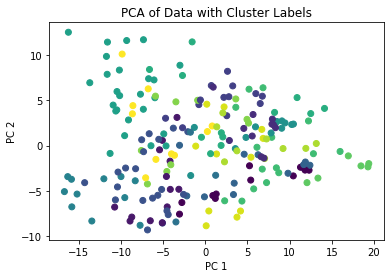

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA model to reduce the dimensionality of the data
pca_model = PCA(n_components=2, random_state=1)

labels = clusters_with_labels['Cluster_Labels']

pca_data = pca_model.fit_transform(clusters_with_labels.drop('Cluster_Labels', axis=1))

# Create a scatter plot of the reduced data with points colored by cluster label
plt.scatter(pca_data[:,0], pca_data[:,1], c=clusters_with_labels['Cluster_Labels'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of Data with Cluster Labels')


# plt.legend(['A','B'])
plt.show()


In [12]:
clusters_with_labels.to_csv('data/clusters_with_labels.csv')

In [13]:
clusters_with_labels.groupby('Cluster_Labels').mean()

,Points,Points per player's possession,Field goals made,Field goals attempted,"Field goals, %",2-pt field goals made,2-pt field goals attempted,"2-pt field goals, %",3-pt field goals made,3-pt field goals attempted,...,Right drives made,Right drives,"Right drives made, %",Left drives made,Left drives,"Left drives made, %",Opp Drives shots made,Opp Drives shots,"Opponent Drives shots made, %",minutes_in_seconds
Cluster_Labels,,,,,,,,,,,,,,,,,,,,,
0,-1.701194,-0.208156,-1.594810,-1.613720,-0.445864,-1.478842,-1.075281,-0.334730,0.452440,0.002513,...,-0.146713,-0.281360,0.020921,-0.135527,-0.050188,0.081884,0.944965,1.415445,0.497322,-2.310091
1,1.053670,0.188010,1.095712,1.826499,0.153851,0.935733,0.868141,0.633945,-0.102096,0.298231,...,1.776496,1.695883,1.207256,1.035358,0.772047,1.037296,1.357535,0.262834,1.553699,-0.250533
2,-1.342708,-1.168365,-0.898558,0.436527,-0.957314,-0.073312,0.521013,-1.106147,-2.085980,-1.811530,...,0.944308,1.055730,0.503846,-2.186560,-1.716828,-1.405739,0.309245,-0.385015,0.229451,-0.516193
3,0.122186,-0.157828,0.008964,-1.614304,0.074420,0.284974,-0.313122,0.180930,-1.183981,-1.528519,...,-1.337359,-1.113655,-0.822633,0.015702,-0.234469,0.345655,-1.470487,-1.151356,-1.127373,-1.226371
4,1.406521,0.794498,1.345749,0.883885,0.702758,0.816311,0.717315,0.727966,0.922986,0.773527,...,0.656745,0.519717,0.865321,1.209613,1.125924,1.015213,0.500401,0.715585,0.489918,1.099301
5,-0.501393,-0.130588,-0.465599,-0.223823,-0.256265,-1.115200,-1.293279,-0.327713,0.502562,0.381764,...,-0.497049,-0.710472,-0.259990,-0.534432,-1.104754,-0.954991,-0.112626,0.122902,0.093616,-1.850928
6,0.031825,0.986475,0.200095,0.462000,1.921066,-0.163386,0.060119,0.084361,0.775214,0.096258,...,1.112093,1.834003,0.757177,-1.512397,-1.377429,-1.484530,-0.487943,0.101630,-0.310992,0.149928
7,1.971328,1.067398,1.880521,2.045153,0.955592,1.923584,2.312295,1.091060,0.737693,0.878825,...,2.264997,2.445698,1.959267,1.780133,1.800595,2.007537,1.291765,1.647461,1.345264,1.470981
8,-0.399331,-0.128761,-1.317614,-0.988059,-0.487692,-2.017025,-2.448505,-0.471877,0.816056,1.063160,...,-1.233274,-1.367982,-0.888675,-0.506001,-1.224999,-0.209636,-0.792883,-0.663457,-0.839980,0.284253


In [14]:
# clusters_with_labels.sample(15).to_csv('data/sample_set_of_players.csv')
clusters_with_labels.to_csv('data/all_set_of_players.csv')

In [16]:
clusters_with_labels

,,,Points,Points per player's possession,Field goals made,Field goals attempted,"Field goals, %",2-pt field goals made,2-pt field goals attempted,"2-pt field goals, %",3-pt field goals made,3-pt field goals attempted,...,Right drives,"Right drives made, %",Left drives made,Left drives,"Left drives made, %",Opp Drives shots made,Opp Drives shots,"Opponent Drives shots made, %",minutes_in_seconds,Cluster_Labels
id,player_name,team_name,,,,,,,,,,,,,,,,,,,,,
0,Jordan McRae,Hapoel SP Tel Aviv,0.323011,0.098485,0.146392,1.526017,-0.355960,-0.301946,-0.116089,-0.370666,1.878927,2.467021,...,0.404777,-0.932415,1.206362,1.586438,-0.183693,-0.476008,-0.239608,-0.622679,1.158308,15
1,Xavier Munford,Hapoel SP Tel Aviv,-0.119143,0.114373,-0.411176,1.060169,-0.384085,-0.998388,-0.875851,-0.277780,1.960904,2.632529,...,1.030772,-0.482878,0.727194,1.327334,-0.142203,1.092025,1.051366,0.403170,1.049630,15
2,J'Covan Brown,Hapoel SP Tel Aviv,-0.445170,-0.302963,-0.743531,0.766967,-0.804552,-1.465262,-1.141860,-0.684001,2.119392,2.431783,...,0.044589,-1.604921,1.030667,1.301423,0.362364,-1.006727,-1.223448,-1.174764,0.970262,15
3,Tomer Ginat,Hapoel SP Tel Aviv,-0.423616,0.317041,-0.168574,0.988058,0.043033,-0.112789,-0.083979,-0.046303,0.690916,1.351175,...,0.319018,-1.445177,-0.383261,0.048262,-1.680184,0.218981,-0.562251,0.506441,0.800923,15
4,Idan Zalmanson,Hapoel SP Tel Aviv,-1.245993,-0.144148,-1.104310,0.117196,0.095209,-0.897791,-0.831268,-0.125447,0.015324,0.693414,...,-0.209661,-2.554343,-0.550590,-0.218656,-1.985201,0.054711,-0.332423,0.487821,-0.253715,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Nadav Malka,Hapoel Nofar Energy Galil E,-1.480304,-1.848220,-1.438368,-2.140527,-1.604724,-1.454546,-1.625528,-1.779390,-0.613250,-1.051334,...,-0.437215,0.079456,-0.398494,-0.159093,-0.880526,0.133041,-0.599437,-0.245668,-2.238457,14
204,Briante Weber,Bnei Herzliya,0.254400,0.908621,0.424738,0.676969,1.161659,0.110657,0.139128,0.907261,0.130625,0.114485,...,1.472782,0.300963,0.750075,0.246842,0.018311,0.422777,0.775999,1.900004,-0.857466,6
205,Ron Zipper,Hapoel Altshuler Shaham Be',-1.373051,-1.948302,-1.832106,-1.957493,-1.836736,-1.985568,-2.095288,-1.881992,-0.222201,-0.218013,...,-1.834919,-0.838101,-2.075003,-2.004550,-2.383135,-1.558064,-1.388525,-1.600385,-0.773018,10
